In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division

import pandas as pd
import numpy as np
import has_violation
import epa_pipeline as ep
import grids as gr
import ml_pipe as ml
import new_pipe as npi

from sklearn import preprocessing, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
#from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *

from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
from scipy import optimize
import time
import seaborn as sns

from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [81]:
def define_clfs_params(grid_size):
    '''
    Define defaults for different classifiers.
    Define three types of grids:
    Test: for testing your code
    Small: small grid
    Large: Larger grid that has a lot more parameter sweeps
    Inputs:
        grid_size(str): Can be either 'large_grid', 'small_grid' or 'test_grid'
    Returns:
        clfs(ditionary): classifiers that will be used
        grid size(dictionary): parameters that will be used 
    '''

    ## dictionary of classifier methods. RF: Random Forests, ET: Extra Trees Classifier, 
    ## AB: Boosting Classifier (ADA), GB: Gradient Boosting Classifier, LR: Logistic Regression, 
    ## SVM: Support Vector Machines, DT: Decision Trees, KNN: K-Nearest Neighbors, 
    clfs = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
        'ET': ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='entropy'),
        'AB': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
        'LR': LogisticRegression(penalty='l1', C=1e5),
        'SVM': svm.SVC(kernel='linear', probability=True, random_state=0),
        'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
        'NB': GaussianNB(),
        'DT': DecisionTreeClassifier(),
        'SGD': SGDClassifier(loss="hinge", penalty="l2"),
        'KNN': KNeighborsClassifier(n_neighbors=3), 
        'BAG': BaggingClassifier(DecisionTreeClassifier(), max_samples= 0.5, n_estimators = 20) 
            }

    
    large_grid = { 
    'RF':{'n_estimators': [1,10,100,1000,10000], 'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.0001,0.001,0.01,0.1,1,10]},
    'SGD': { 'loss': ['hinge','log','perceptron'], 'penalty': ['l2','l1','elasticnet']},
    'ET': { 'n_estimators': [1,10,100,1000,10000], 'criterion' : ['gini', 'entropy'] ,'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10], 'n_jobs': [-1]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [1,10,100,1000,10000], 'learning_rate' : [0.001,0.01,0.05,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [1,3,5,10,20,50,100]},
    'NB' : {},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']},
    'BAG': {'n_estimators' : [5,10, 20], 'max_samples' : [.25, .5, .75]}
       }
    
    small_grid = { 
    'RF':{'n_estimators': [10,100,1000,10000], 'max_depth': [1,5,50,100], 'min_samples_split': [2,10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.0001,0.001,0.01,0.1,1,10],'solver': ['liblinear']},
    'SGD': { 'loss': ['hinge','log','perceptron'], 'penalty': ['l2','l1','elasticnet']},
    'ET': { 'n_estimators': [1,10,100,10000], 'criterion' : ['gini'] ,'max_depth': [5,50],'min_samples_split': [2,10], 'n_jobs': [-1]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [10,100], 'learning_rate' : [0.1,0.5],'subsample' : [0.5,1.0], 'max_depth': [5,50]},
    'NB' : {},
    'DT': {'criterion': ['gini'], 'max_depth': [1,5,10,20,50,100],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.1],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']},
    'BAG': {'n_estimators' : [5,10, 20], 'max_samples' : [.25, .5, .75] } 
           }
    
    test_grid = { 
    'RF':{'n_estimators': [1], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'LR': { 'penalty': ['l1'], 'C': [0.01]},
    'SGD': { 'loss': ['perceptron'], 'penalty': ['l2']},
    'ET': { 'n_estimators': [1], 'criterion' : ['gini'] ,'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'AB': { 'algorithm': ['SAMME'], 'n_estimators': [1]},
    'GB': {'n_estimators': [1], 'learning_rate' : [0.1],'subsample' : [0.5], 'max_depth': [1]},
    'NB' : {},
    'DT': {'criterion': ['gini'], 'max_depth': [1],'min_samples_split': [10]},
    'SVM' :{'C' :[0.01],'kernel':['linear']},
    'KNN' :{'n_neighbors': [5],'weights': ['uniform'],'algorithm': ['auto']},
    'BAG': {'n_estimators' : [5], 'max_samples' : [.25] } 

           }
    
    if (grid_size == 'large'):
        return clfs, large_grid
    elif (grid_size == 'small'):
        return clfs, small_grid
    elif (grid_size == 'test'):
        return clfs, test_grid
    else:
        return 0, 0



def temp_holdout_prep(facilities_csv, evaluations_csv, violations_csv,
                     snc_csv, sd):
    FACILITIES = pd.read_csv(facilities_csv)
    EVALS = pd.read_csv(evaluations_csv)
    EVALS = cl.clean_converttodatetime_dashes(EVALS, 'EVALUATION_START_DATE',
                                              sd)
    print('evals begin: ', EVALS['EVALUATION_START_DATE'].min())
    print('evals end: ', EVALS['EVALUATION_START_DATE'].max())
    VIOLATIONS = pd.read_csv(violations_csv)
    VIOLATIONS = cl.clean_and_converttodatetime_slashes(VIOLATIONS,
                                           'DATE_VIOLATION_DETERMINED', sd)
    print('vios begin: ', VIOLATIONS['DATE_VIOLATION_DETERMINED'].min())
    print('vios end: ', VIOLATIONS['DATE_VIOLATION_DETERMINED'].max())
    SNC = pd.read_csv(snc_csv)
    SNC = cl.yr_month_to_datetime(SNC, 'YRMONTH', sd)
    print('SNC begin: ', SNC['YRMONTH'].min())
    print('SNC end: ', SNC['YRMONTH'].max())

    return FACILITIES, EVALS, VIOLATIONS, SNC

#create temporal test and train features and true Y values
def temporal_split(evals_df, vios_df, snc_df):
    eval_train, eval_test, etr_ends, ete_ends = ml.temp_holdout(evals_df,
                                                              'EVALUATION_START_DATE', 24, 24)
    vio_train, vio_test, vtr_ends, vte_ends = ml.temp_holdout(vios_df, 'DATE_VIOLATION_DETERMINED', 24, 24)
    snc_train, snc_test, str_ends, ste_ends = ml.temp_holdout(snc_df, 'YRMONTH', 24, 24)

    trains = [eval_train, vio_train, snc_train]
    tests = [eval_test, vio_test, snc_test]
    train_ends = etr_ends
    test_ends = ete_ends

    return trains, tests, train_ends, test_ends

    

def roc_auc_sc(y_test_sorted,y_pred_probs_sorted):
    '''
    Gives the auc score 
    Input:
        y_test_sorted(array): true label from testing data
        y_pred_probs_sorted: predicted probabilities for label
    Returns:
        auc score
    '''
    return metrics.roc_auc_score(y_test_sorted,y_pred_probs_sorted)


def joint_sort_descending(l1, l2):
    # l1 and l2 have to be numpy arrays

    '''
    Order the specified arrays into descending (see which ones got the highest score)

    Intputs: 
        l1: first array
        l2: second array
    Returns: 
        The sorted data
    '''
    idx = np.argsort(l1)[::-1]
    return l1[idx], l2[idx]

def generate_binary_at_k(y_scores, k):
    '''
    Makes the cutoff for keeping only the observations that are within the top k%
    Input:
        y_scores: Predicted label
        k: threshold for keeping the points
    '''
    cutoff_index = int(len(y_scores) * (k / 100.0))
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary

def precision_at_k(y_true, y_scores, k):
    y_scores, y_true = joint_sort_descending(np.array(y_scores), np.array(y_true))
    preds_at_k = generate_binary_at_k(y_scores, k)
    #precision, _, _, _ = metrics.precision_recall_fscore_support(y_true, preds_at_k)
    #precision = precision[1]  # only interested in precision for label 1
    precision = precision_score(y_true, preds_at_k)
    return precision

def recall_at_k(y_true, y_scores, k):
    #y_scores_sorted, y_true_sorted = zip(*sorted(zip(y_scores, y_true), reverse=True))
    y_scores_sorted, y_true_sorted = joint_sort_descending(np.array(y_scores), np.array(y_true))
    preds_at_k = generate_binary_at_k(y_scores_sorted, k)
    #precision, _, _, _ = metrics.precision_recall_fscore_support(y_true, preds_at_k)
    #precision = precision[1]  # only interested in precision for label 1
    recall = recall_score(y_true_sorted, preds_at_k)
    return recall

def f1_at_k(y_true, y_scores, k):
    '''
    Calculates the F1 score of a determined k% testing sample

    Inputs:
        y_true: label from test data
        y_scores: predicted label for test data
        k: k%, the % value we want to predict

    Returns: 
        F1 score  
    '''
    y_scores_sorted, y_true_sorted = joint_sort_descending(np.array(y_scores), np.array(y_true))
    preds_at_k = generate_binary_at_k(y_scores_sorted, k)
    recall = recall_score(y_true_sorted, preds_at_k)
    precision = precision_score(y_true_sorted, preds_at_k)
    prec_rec = precision + recall
    if prec_rec == 0:
        F1 = 0
    else:
        F1 = 2 * (precision * recall) / (precision + recall)
    return F1


def clf_loop(models_to_run, clfs, grid, X_train_lst, y_train_lst, X_test_lst, y_test_lst, 
             metric_lst, k_lst,quantiles, rococo = True):
    '''
    Runs the loop using models_to_run, clfs, gridm and the data
    Inputs:
        models_to_run(list): list of models to run
        clfs(dictionary of objects): dictionary with model objects
        grid(str): parameter options
        temp_var(str): temporal feature
        label(str): label feature
        validation_lst(list): list of dates for spliting data temporally
    '''
    NOTEBOOK = 0

    ### Creates the final dataframe with the needed columns
    colnames = ['train_end_date','model_type','clf', 'parameters', 'str_param'] 
    colnames = colnames + define_colnames(metric_lst,k_lst)

    results_df =  pd.DataFrame(columns=(colnames))
    '''
    for elem in validation_lst:
        # create training and valdation sets
        X_train, X_test, y_train, y_test = temp_spl(data,temp_var,elem,label)       
        X_train = clean_data(X_train,quantiles)
        X_test = clean_data(X_test,quantiles)
        X_train = np.array(X_train)
        X_test = np.array(X_test)
        
    '''
    for temp_i in range(len(list_of_trainx)):
        X_train =  np.array(X_train_lst[temp_i])
        y_train = np.array(y_train_lst[temp_i])
        X_test = np.array( X_test_lst[temp_i])
        y_test =  np.array(y_test_lst[temp_i]) 
        for index,clf in enumerate([clfs[x] for x in models_to_run]):
            print(models_to_run[index])
            parameter_values = grid[models_to_run[index]]
            for p in ParameterGrid(parameter_values):
                try:
                    clf.set_params(**p)
                    y_pred_probs = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
                    #y_pred = clf.fit(X_train, y_train).predict(X_test)[:,1]
                    # you can also store the model, feature importances, and prediction scores
                    # we're only storing the metrics for now
                    #y_pred_probs_sorted, y_pred_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_pred, y_test), reverse=True))
                    y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs,y_test), reverse=True))
                    #y_pred_sorted, y_test_sorted_ = zip(*sorted(zip(y_pred,y_test), reverse=True))
                    
                    final_lst = evaluate_models(metric_lst, k_lst,y_test_sorted,y_pred_probs_sorted, rococo)
                    total_lst = [temp_i,models_to_run[index],clf, p, str(p)] + final_lst
                    results_df.loc[len(results_df)] = total_lst

                    if NOTEBOOK == 1:
                        plot_precision_recall_n(y_test,y_pred_probs,clf)
                except IndexError as e:
                    print('Error:',e)
                    continue
    return results_df


def evaluate_models(metric_lst, k_lst,y_test_sorted,y_pred_probs_sorted, rococo = True):
    '''
    Creates a list of the evaluation metrics especified. 

    Inputs: 
        metric_lst (list)
        precision_lst(list)
        y_test_sorted(array)
        y_pred_probs(array)

    '''
    final_lst = []
    mtr_lst = metric_lst
    if rococo == True:
        final_lst.append(roc_auc_sc(y_test_sorted,y_pred_probs_sorted))
    for metr in mtr_lst:
        for prec in k_lst:
            final_lst.append(metr(y_test_sorted,y_pred_probs_sorted,prec))

    return final_lst


def define_colnames(metric_lst,k_lst, rococo = True):
    '''
    Defines the names we want to assign to the columns
    '''

    final_lst = []
    names = {roc_auc_sc:'roc_auc',precision_at_k:'p_at_',recall_at_k: 'r_at_',f1_at_k: 'f1_at_'}
    mtr_lst = metric_lst
    if rococo == True:
        final_lst.append(names[roc_auc_sc])
    print(final_lst)
    for mtr in mtr_lst:
        for k in k_lst:
            final_lst.append(names[mtr] +'{}'.format(k))
    return final_lst


def rank_classifiers(df,feat,criteria):
    aa = df.groupby([feat])
    lst_to_keep = []
    output_df = None
    for key, gr in aa:
        add_ord = gr[[criteria]]
        add_ord.drop_duplicates(inplace = True)
        add_ord.sort_values(by =criteria,ascending=False,inplace=True)
        add_ord[str(key)] = np.arange(len(add_ord))
        gr.sort_values(by=criteria, ascending=False,inplace=True)
        total_df = pd.merge(gr,add_ord,on = criteria)
        total_df = total_df[['model_type','clf','parameters','str_param',str(key)]]
        if output_df is None:
            output_df = total_df
        else:
            output_df = pd.merge(output_df,total_df,on = ['model_type', 'str_param'])
        lst_to_keep.append(str(key))
    lst_to_keep = ['model_type','clf','parameters','str_param'] + lst_to_keep 
        
    return output_df[lst_to_keep]

def accurate(y_test_sorted_,y_pred_sorted):
    '''
    Calculates the accuracy score of a determined k% testing sample

    Inputs:
        y_test_sorted: label from test data
        y_pred_sorted: predicted label for test data

    Returns: 
        accuracy score  
    '''

    accure = metrics.accuracy_score(y_test_sorted_,y_pred_sorted)
    return accure

def plot_precision_recall_n(y_true, y_prob, model_name):

    '''
    Plots the precision-recall sample for the specified model

    Inputs:
        y_test_sorted_: label from test data
        y_pred_sorted: predicted label for test data

    Returns: 
        Image with the precision recall curve
    '''

    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax1.set_ylim([0,1])
    ax1.set_ylim([0,1])
    ax2.set_xlim([0,1])
    
    name = model_name
    plt.title(name)
    #plt.savefig(name)
    plt.show()




def plot_roc(name, probs, true, output_type):
    '''
    Plots the AUC for the specified model

    Input:
        name(string): name we want to assign to the model
        probs(array): predicted label for test data
        true(array): label for true data
        output_types()
    
    '''
    fpr, tpr, thresholds = roc_curve(true, probs)
    roc_auc = auc(fpr, tpr)
    plt.clf()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.legend(loc="lower right")
    if (output_type == 'save'):
        plt.savefig(name)
    elif (output_type == 'show'):
        plt.show()
    else:
        plt.show()

In [23]:
clfs, grid = define_clfs_params('small')
models_to_run=['RF','DT','LR','ET','BAG','GB','NB','AB']
metric_lst =[precision_at_k,recall_at_k,f1_at_k]
k_lst = [1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0]

In [24]:
df = pd.read_csv('new_small_data_cleaned.csv')

In [25]:
df.drop(columns = 'Unnamed: 0', inplace = True, axis = 1)

In [26]:
list_of_trainx, list_of_trainy, list_of_testx, list_of_testy, features = npi.temporal_split(df)

In [27]:
#results_df_ = clf_loop(models_to_run,clfs,grid,list_of_trainx, list_of_trainy, list_of_testx, 
                       #list_of_testy,metric_lst,k_lst,10)

['roc_auc']
RF
DT
LR
ET
BAG
GB
NB
AB
RF
DT
LR
ET
BAG
GB
NB
AB
RF
DT
LR
ET
BAG
GB
NB
AB
RF
DT
LR
ET
BAG
GB
NB
AB
RF
DT
LR
ET
BAG
GB
NB
AB


In [15]:
prec_df = final_df[['model_type','train_end_date','p_at_20.0']]
precision_graph = prec_df.pivot(index='train_end_date', columns='model_type', values='p_at_20.0')
precision_graph.plot()

NameError: name 'results_df_' is not defined

In [23]:
for i in range(len(list_of_trainx)):
    X_traini = list_of_trainx[i]
    y_train = list_of_trainy[i]
    X_test = list_of_testx[i]
    y_test = list_of_testy[i]
    

In [35]:
results_df_.to_csv('RESULTS_OF_RUN.csv')

In [38]:
results_df_.columns

Index(['train_end_date', 'model_type', 'clf', 'parameters', 'str_param',
       'roc_auc', 'p_at_1.0', 'p_at_2.0', 'p_at_5.0', 'p_at_10.0', 'p_at_20.0',
       'p_at_30.0', 'p_at_40.0', 'p_at_50.0', 'r_at_1.0', 'r_at_2.0',
       'r_at_5.0', 'r_at_10.0', 'r_at_20.0', 'r_at_30.0', 'r_at_40.0',
       'r_at_50.0', 'f1_at_1.0', 'f1_at_2.0', 'f1_at_5.0', 'f1_at_10.0',
       'f1_at_20.0', 'f1_at_30.0', 'f1_at_40.0', 'f1_at_50.0'],
      dtype='object')

In [37]:
def rank_classifiers(df,feat,criteria):
    aa = df.groupby([feat])
    lst_to_keep = []
    output_df = None
    for key, gr in aa:
        add_ord = gr[[criteria]]
        add_ord.drop_duplicates(inplace = True)
        add_ord.sort_values(by =criteria,ascending=False,inplace=True)
        add_ord[str(key)] = np.arange(len(add_ord))
        gr.sort_values(by=criteria, ascending=False,inplace=True)
        total_df = pd.merge(gr,add_ord,on = criteria)
        total_df = total_df[['model_type','clf','parameters','str_param',str(key)]]
        if output_df is None:
            output_df = total_df
        else:
            output_df = pd.merge(output_df,total_df,on = ['model_type', 'str_param'])
        lst_to_keep.append(str(key))
    lst_to_keep = ['model_type','clf','parameters','str_param'] + lst_to_keep
    return output_df[lst_to_keep]

In [39]:
output = rank_classifiers(results_df_,'train_end_date','p_at_20.0')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10:

In [43]:
pd.options.display.max_colwidth = 130
pd.set_option('display.max_rows', 1000)
output.sort_values(by ='4',ascending=True,inplace=True)
output

,model_type,clf,parameters,str_param,0,1,2,3,4
35,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=50,\n max_features=None, max_leaf_nodes=None,\n ...","{'n_estimators': 10, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5}","{'n_estimators': 10, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5}",21,31,2,8,0
45,AB,"(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,\n max_features=None, max_leaf_nodes=None,...","{'n_estimators': 100, 'algorithm': 'SAMME'}","{'n_estimators': 100, 'algorithm': 'SAMME'}",29,21,11,10,1
44,AB,"(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,\n max_features=None, max_leaf_nodes=None,...","{'n_estimators': 1000, 'algorithm': 'SAMME'}","{'n_estimators': 1000, 'algorithm': 'SAMME'}",29,23,8,8,2
50,AB,"(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,\n max_features=None, max_leaf_nodes=None,...","{'n_estimators': 10000, 'algorithm': 'SAMME'}","{'n_estimators': 10000, 'algorithm': 'SAMME'}",32,19,10,12,3
27,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=50,\n max_features=None, max_leaf_nodes=None,\n ...","{'n_estimators': 100, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5}","{'n_estimators': 100, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5}",16,6,1,1,4
59,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=50,\n max_features=None, max_leaf_nodes=None,\n ...","{'n_estimators': 100, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 5}","{'n_estimators': 100, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 5}",40,24,15,9,5
38,AB,"(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,\n max_features=None, max_leaf_nodes=None,...","{'n_estimators': 100, 'algorithm': 'SAMME.R'}","{'n_estimators': 100, 'algorithm': 'SAMME.R'}",23,9,16,25,6
43,AB,"(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,\n max_features=None, max_leaf_nodes=None,...","{'n_estimators': 10, 'algorithm': 'SAMME.R'}","{'n_estimators': 10, 'algorithm': 'SAMME.R'}",28,25,35,26,7
7,RF,"(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=100,\n max_features='auto', max_leaf_nodes=N...","{'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'max_depth': 5}","{'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'max_depth': 5}",6,14,3,12,7
15,RF,"(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=100,\n max_features='auto', max_leaf_nodes=N...","{'min_samples_split': 10, 'n_estimators': 1000, 'n_jobs': -1, 'max_depth': 5}","{'min_samples_split': 10, 'n_estimators': 1000, 'n_jobs': -1, 'max_depth': 5}",9,2,8,6,8


In [57]:
best_lst = ["{'n_estimators': 10, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5}",
           "{'n_estimators': 100, 'algorithm': 'SAMME'}",
           "{'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'max_depth': 5}",
           "{'min_samples_split': 10, 'n_estimators': 10000, 'criterion': 'gini', 'n_jobs': -1, 'max_depth': 50}",
           "{'min_samples_split': 5, 'criterion': 'gini', 'max_depth': 5}",
           "{'penalty': 'l1', 'solver': 'liblinear', 'C': 1}",
           "{'n_estimators': 5, 'max_samples': 0.5}",
           "{}",
           "{'min_samples_split': 5, 'criterion': 'gini', 'max_depth': 1}"]

best_mod_df = pd.DataFrame(best_lst,columns =['str_param']) 
final_df = pd.merge(best_mod_df,results_df_,how = "left", on = "str_param")

best_model_lst = ["ET{'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 1, 'n_jobs': -1}",
                 "DT{'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 10}",
                 "GB{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 10, 'subsample': 1.0}",
                 "LR{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}"]
best_mod_df = pd.DataFrame(best_model_lst,columns =['model']) 


In [58]:
final_df

,str_param,train_end_date,model_type,clf,parameters,roc_auc,p_at_1.0,p_at_2.0,p_at_5.0,p_at_10.0,...,r_at_40.0,r_at_50.0,f1_at_1.0,f1_at_2.0,f1_at_5.0,f1_at_10.0,f1_at_20.0,f1_at_30.0,f1_at_40.0,f1_at_50.0
0,"{'n_estimators': 10, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5}",0,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=50,\n max_features=None, max_leaf_nodes=None,\n ...","{'n_estimators': 10, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5}",0.734352,0.448113,0.356132,0.251649,0.179076,...,0.715706,0.792247,0.155993,0.211189,0.258345,0.242967,0.197296,0.174397,0.151627,0.137177
1,"{'n_estimators': 10, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5}",1,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=50,\n max_features=None, max_leaf_nodes=None,\n ...","{'n_estimators': 10, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5}",0.727871,0.464646,0.421717,0.287588,0.203330,...,0.627230,0.837559,0.145685,0.228611,0.277237,0.264522,0.203181,0.188507,0.148510,0.162492
2,"{'n_estimators': 10, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5}",2,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=50,\n max_features=None, max_leaf_nodes=None,\n ...","{'n_estimators': 10, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5}",0.715240,0.436548,0.408629,0.276876,0.210340,...,0.666352,0.764650,0.137052,0.221763,0.267123,0.273837,0.213786,0.186273,0.157489,0.148074
3,"{'n_estimators': 10, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5}",3,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=50,\n max_features=None, max_leaf_nodes=None,\n ...","{'n_estimators': 10, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5}",0.746607,0.316940,0.340599,0.272331,0.211329,...,0.717039,0.818458,0.099230,0.184775,0.262605,0.274982,0.217214,0.188761,0.169707,0.158733
4,"{'n_estimators': 10, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5}",4,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=50,\n max_features=None, max_leaf_nodes=None,\n ...","{'n_estimators': 10, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5}",0.752962,0.446809,0.382979,0.237792,0.210191,...,0.725568,0.817374,0.139883,0.207343,0.229156,0.273386,0.237139,0.201590,0.171890,0.158666
5,"{'n_estimators': 100, 'algorithm': 'SAMME'}",0,AB,"(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,\n max_features=None, max_leaf_nodes=None,...","{'n_estimators': 100, 'algorithm': 'SAMME'}",0.726143,0.391509,0.386792,0.268615,0.183789,...,0.682903,0.767396,0.136289,0.229371,0.275762,0.249361,0.191963,0.161378,0.144677,0.132874
6,"{'n_estimators': 100, 'algorithm': 'SAMME'}",1,AB,"(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,\n max_features=None, max_leaf_nodes=None,...","{'n_estimators': 100, 'algorithm': 'SAMME'}",0.733726,0.570707,0.421717,0.296670,0.205348,...,0.696714,0.781221,0.178939,0.228611,0.285992,0.267148,0.213917,0.185655,0.164962,0.151562
7,"{'n_estimators': 100, 'algorithm': 'SAMME'}",2,AB,"(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,\n max_features=None, max_leaf_nodes=None,...","{'n_estimators': 100, 'algorithm': 'SAMME'}",0.704654,0.543147,0.441624,0.303245,0.199696,...,0.672023,0.749527,0.170518,0.239669,0.292564,0.259980,0.204995,0.175383,0.158829,0.145145
8,"{'n_estimators': 100, 'algorithm': 'SAMME'}",3,AB,"(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,\n max_features=None, max_leaf_nodes=None,...","{'n_estimators': 100, 'algorithm': 'SAMME'}",0.728685,0.459016,0.444142,0.309368,0.208606,...,0.683570,0.746450,0.143713,0.240946,0.298319,0.271439,0.215926,0.184142,0.161786,0.144768
9,"{'n_estimators': 100, 'algorithm': 'SAMME'}",4,AB,"(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,\n max_features=None, max_leaf_nodes=None,...","{'n_estimators': 100, 'algorithm': 'SAMME'}",0.759547,0.452128,0.401596,0.297240,0.213907,...

In [59]:
final_df.replace({"train_end_date": {0: 'Split 1',1: 'Split 2',2: 'Split 3',3: 'Split 4',4: 'Split 5'}}, inplace= True)
final_df.loc[final_df['str_param'] == "{'min_samples_split': 5, 'criterion': 'gini', 'max_depth': 1}", 'model_type'] = 'BL'

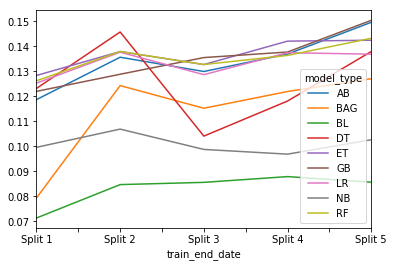

In [75]:
df_prec = final_df[['model_type', 'p_at_20.0', 'train_end_date']]
prec_graph = df_prec.pivot(index='train_end_date', columns='model_type', values='p_at_20.0')
prec_graph.plot()

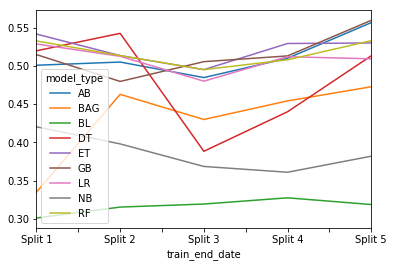

In [76]:
df_rec = final_df[['model_type', 'r_at_20.0', 'train_end_date']]
rec_graph = df_rec.pivot(index='train_end_date', columns='model_type', values='r_at_20.0')
rec_graph.plot()

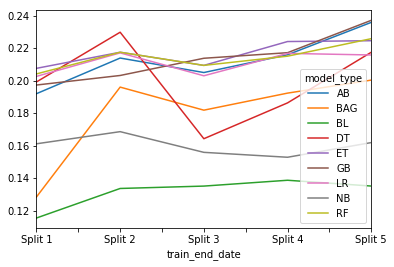

In [77]:
f1_rec = final_df[['model_type', 'f1_at_20.0', 'train_end_date']]
f1_graph = f1_rec.pivot(index='train_end_date', columns='model_type', values='f1_at_20.0')
f1_graph.plot()

In [71]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier

clf = GradientBoostingClassifier()
clf.set_params(**output['parameters'][35])
y_pred_probs = clf.fit(list_of_trainx[4], list_of_trainy[4]).predict_proba(list_of_testx[4])[:,1]
                    #y_pred = clf.fit(X_train, y_train).predict(X_test)[:,1]
                    # you can also store the model, feature importances, and prediction scores
                    # we're only storing the metrics for now
                    #y_pred_probs_sorted, y_pred_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_pred, y_test), reverse=True))
y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs,list_of_testy[4]), reverse=True))


<Figure size 432x288 with 0 Axes>

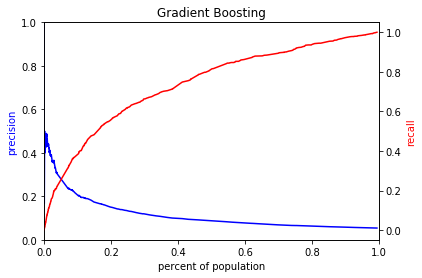

In [74]:
plot_precision_recall_n(list_of_testy[4],y_pred_probs,"Gradient Boosting")

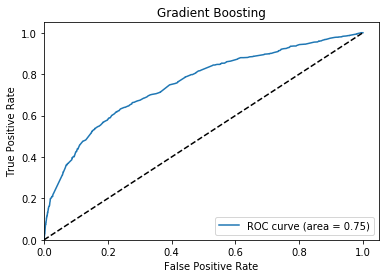

In [82]:
plot_roc('Gradient Boosting', y_pred_probs,list_of_testy[4],'show')

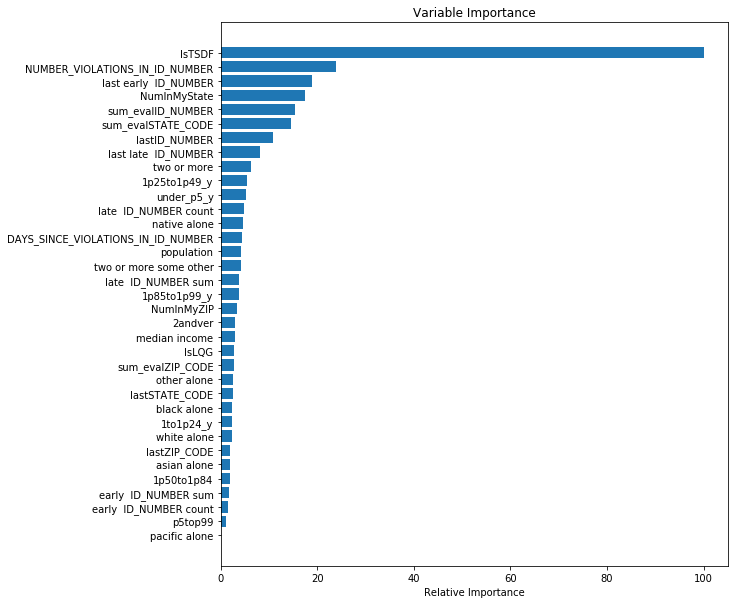

In [100]:
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, list_of_trainx[4].columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [96]:
list_of_trainx[4].columns[sorted_idx]

Index(['pacific alone', 'p5top99', 'early  ID_NUMBER count',
       'early  ID_NUMBER sum', '1p50to1p84', 'asian alone', 'lastZIP_CODE',
       'white alone', '1to1p24_y', 'black alone', 'lastSTATE_CODE',
       'other alone', 'sum_evalZIP_CODE', 'IsLQG', 'median income', '2andver',
       'NumInMyZIP', '1p85to1p99_y', 'late  ID_NUMBER sum',
       'two or more some other', 'population',
       'DAYS_SINCE_VIOLATIONS_IN_ID_NUMBER', 'native alone',
       'late  ID_NUMBER count', 'under_p5_y', '1p25to1p49_y', 'two or more',
       'last late  ID_NUMBER', 'lastID_NUMBER', 'sum_evalSTATE_CODE',
       'sum_evalID_NUMBER', 'NumInMyState', 'last early  ID_NUMBER',
       'NUMBER_VIOLATIONS_IN_ID_NUMBER', 'IsTSDF'],
      dtype='object')

In [87]:
sorted_idx

array([16, 30,  8,  3, 23, 20,  9, 18, 19,  7, 17, 11, 24, 31, 25, 28, 14,
       22, 33,  4, 13,  6, 32, 26,  5, 29, 10,  1, 27, 21, 34, 12, 15,  2,
        0])

In [89]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
boston = datasets.load_boston()
Xb, yb = shuffle(boston.data, boston.target, random_state=13)
Xb = Xb.astype(np.float32)

In [91]:
boston.feature_names[sorted_idx]

IndexError: index 16 is out of bounds for axis 0 with size 13